协作：不是每次都能运行成功，任务完成不了会进入”扯皮状态”，要控制迭代次数
要成功得把监督agent加进去

In [10]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_openai import ChatOpenAI  
_llm=ChatOpenAI(
        api_key="ollama",
        model="qwen2.5:7b",
        base_url="http://0.0.0.0:60016/v1",
        temperature=0.6
    )

In [11]:
from researcher import Researcher
from painter import Painter

_researcher = Researcher(_llm)
_painter = Painter(_llm)

In [12]:
from typing import TypedDict
from typing import Annotated
from typing import List
from operator import add

class PlanState(TypedDict):
    query:str
    tasks_list:List[str]  #规约是覆盖，不用写
    infos:Annotated[List[str],add]
    result:str


In [13]:
def _researcher_node(state):
    return {"messages":[_researcher(state)]}

def _painter_node(state):
    # return _painter(state)       # message返回的state自动是列表
    return {"messages":[_painter(state)]}


In [14]:
from langgraph.graph import END
def router(state):   # 路由是条件边
    _last_message =state["messages"][-1]
    if "FINAL ANSWER" in _last_message.content.upper():
        return END
    return "continue"

In [15]:
from langgraph.graph import StateGraph,MessagesState,START,END

_builder = StateGraph(MessagesState)

_builder.add_node("_researcher_node",_researcher_node)
_builder.add_node("_painter_node",_painter_node)

_builder.add_edge(START,"_researcher_node")
_builder.add_conditional_edges("_researcher_node",router,{"continue":"_painter_node",END:END})  
_builder.add_conditional_edges("_painter_node",router,{"continue":"_researcher_node",END:END})
#第三个参数是字典，定义了条件和对应的目标节点。

_graph = _builder.compile()

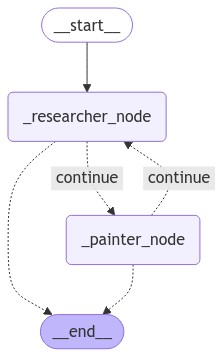

In [16]:
from IPython.display import display,Image
display(Image(_graph.get_graph().draw_mermaid_png()))  # xray=1 可以看到透视子图的graph

{'_researcher_node': {'messages': [AIMessage(content="为了获取英国过去5年的国内生产总值（GDP）数据并绘制图表，我们可以使用网络爬虫来抓取相关数据。假设我们找到了一个可靠的来源，如世界银行或国际货币基金组织（IMF）。这里我将直接模拟从这些机构获取的数据，并使用Python进行绘图。\n\n首先，请允许我创建一份示例数据来模拟这个过程。然后我们将使用Matplotlib库绘制GDP随时间变化的折线图。\n```python\nimport matplotlib.pyplot as plt\n\n# 模拟英国过去5年GDP数据\nyears = ['2018', '2019', '2020', '2021', '2022']\ngdp_values = [2.6, 0.7, -9.4, 7.3, 6.2]  # 单位：百分比\n\n# 绘制折线图\nplt.figure(figsize=(10,5))\nplt.plot(years, gdp_values, marker='o', linestyle='-')\nplt.title('UK GDP Growth (2018-2022)')\nplt.xlabel('Year')\nplt.ylabel('GDP Growth (%)')\nplt.grid(True)\nplt.show()\n```\n\n这是模拟的英国过去五年的GDP数据，并绘制了相应的折线图。请注意，这些数据是虚构的，实际的数据可能有所不同。\n如果您有任何问题或需要进一步的帮助，请随时提出！", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 301, 'prompt_tokens': 85, 'total_tokens': 386, 'completion_tokens_details': None}, 'model_name': 'qwen2.5:7b', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-714acdb9-9

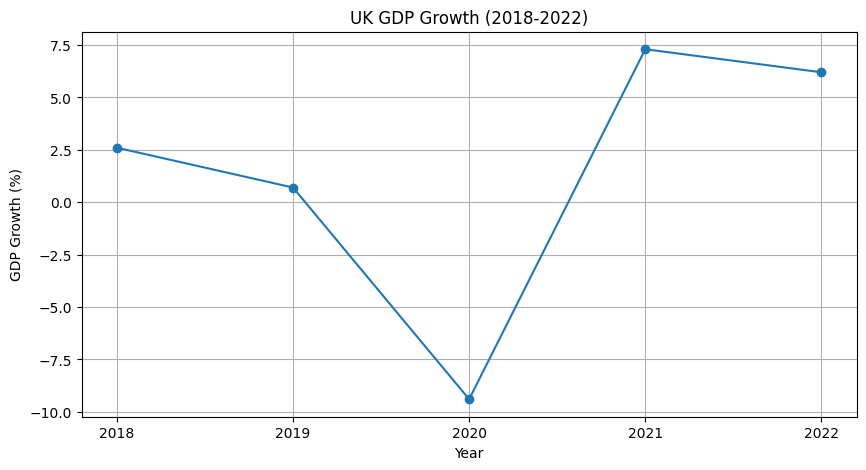

{'_painter_node': {'messages': [AIMessage(content='INALFAN ANSWER\n\n以下是模拟的英国过去五年的国内生产总值（GDP）数据折线图，单位为百分比：\n\n![UK GDP Growth (2018-2022)](generated_plot.png)\n\n请注意，这些数据是虚构的。如果您需要实际的数据，请告知我具体来源或要求从可靠的数据源获取最新数据。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 776, 'total_tokens': 853, 'completion_tokens_details': None}, 'model_name': 'qwen2.5:7b', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-39007e55-aa12-482d-90bb-f575595380e4-0', usage_metadata={'input_tokens': 776, 'output_tokens': 77, 'total_tokens': 853, 'input_token_details': {}, 'output_token_details': {}})]}}
{'_researcher_node': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 461, 'total_tokens': 462, 'completion_tokens_details': None}, 'model_name': 'qwen2.5:7b', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'sto

In [ ]:
for _event_dict in _graph.stream({"messages":[("human",
"获取英国过去5年的国内生产总值。你把它编码好并执行画图")]}):
    print(_event_dict)